In [25]:
# Import libraries and modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [26]:
# Load the data
df = pd.read_csv('stocks.csv')

In [27]:
# Convert all None values to NaN
df = df.replace('None', np.nan)

# Convert all - values to NaN
df = df.replace('-', np.nan)

# Remove any null values from the training set
df.dropna(inplace=True)

# Replace the boolean values in "outperformed" with 1 and 0
df['outperformed'].replace(True, 1, inplace=True)
df['outperformed'].replace(False, 0, inplace=True)

# Cast the columns to the correct data types
df = df.astype(
    {'market_cap': float, 'beta': float, 'ebitda': float, 'pe_ratio': float, 'peg_ratio': float, 'book_value': float,
     'trailing_pe': float, 'forward_pe': float, 'price_to_sales_ratio': float, 'dividend_per_share': float,
     'dividend_yield': float,
     'eps': float, 'price_to_book_ratio': float, 'ev_to_revenue': float, 'ev_to_ebitda': float})

In [28]:
# Drop the returns from both sets
df.drop(['stock_return_100', 'market_return_100'], axis=1, inplace=True)

# Drop the "Unnamed: 0" column from the training set
df.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
# Make the symbols the index
df.set_index('symbol', inplace=True)

df

,sentiment,market_cap,ebitda,pe_ratio,peg_ratio,book_value,dividend_per_share,dividend_yield,eps,revenue_per_share,...,quarterly_earnings_growth,quarterly_revenue_growth,trailing_pe,forward_pe,price_to_sales_ratio,price_to_book_ratio,ev_to_revenue,ev_to_ebitda,beta,outperformed
symbol,,,,,,,,,,,,,,,,,,,,,
A,0.221348,4.101120e+10,2.019000e+09,31.13,2.360,18.960,0.855,0.0065,4.44,23.270,...,0.279,0.049,31.13,26.95,6.500,8.630,6.920,24.870,1.0450,0
AAP,0.159260,7.208287e+09,1.037605e+09,14.71,0.909,45.490,6.000,0.0493,8.27,184.830,...,0.383,0.032,14.71,11.03,0.766,3.130,1.077,12.610,1.1370,0
AAPL,0.134550,2.620581e+12,1.252880e+11,28.17,2.750,3.581,0.910,0.0055,5.88,24.080,...,-0.105,-0.055,28.17,23.09,5.510,44.630,5.920,17.530,1.2970,1
ABB,0.225050,6.393383e+10,4.477000e+09,25.98,0.276,1.713,0.908,0.0268,1.32,3.877,...,-0.546,0.034,25.98,18.98,1.934,5.030,2.207,10.460,1.0240,1
ABBV,0.158136,2.843970e+11,3.108900e+10,24.32,1.279,9.750,5.710,0.0369,6.63,32.780,...,-0.388,0.016,24.32,14.39,4.989,18.230,6.040,13.800,0.5870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTO,0.184920,2.325894e+10,1.040703e+10,23.40,23.960,66.760,0.000,0.0104,1.23,43.700,...,0.197,0.071,23.40,18.45,0.626,2.903,0.594,2.599,0.0137,1
ZTS,0.199179,7.741807e+10,3.332000e+09,37.21,3.526,9.500,1.300,0.0089,4.49,17.230,...,0.125,0.037,37.21,30.12,8.660,15.170,9.370,23.100,0.7590,1
ZUMZ,0.042960,3.716670e+08,5.122600e+07,17.18,0.820,20.900,0.000,0.0000,1.11,49.900,...,-0.651,-0.192,17.18,12.21,0.398,1.162,0.542,6.240,1.5010,0


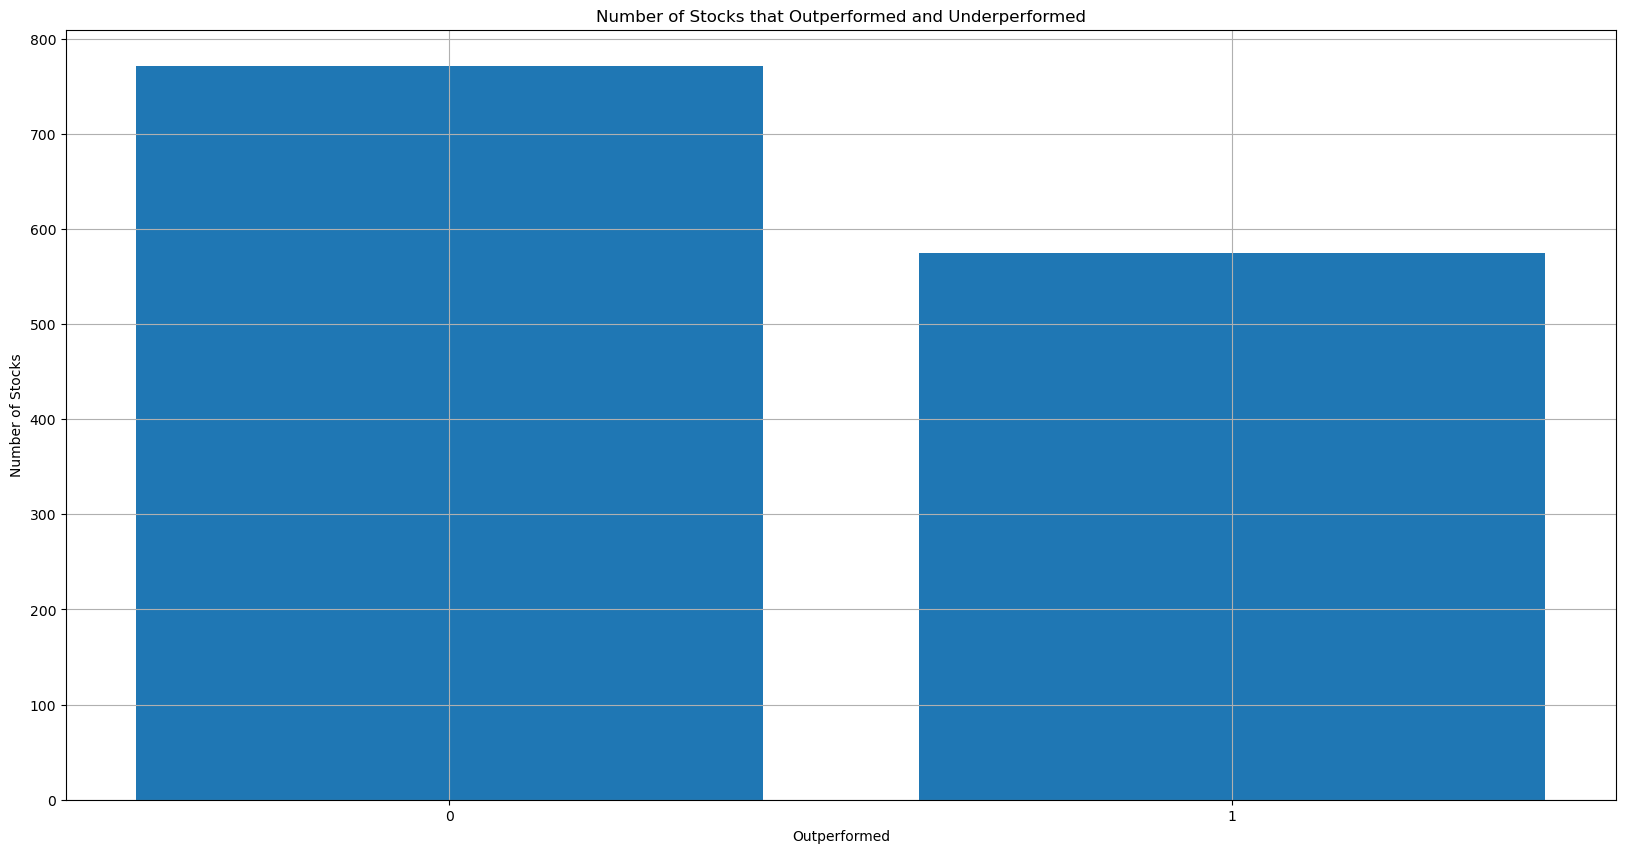

In [30]:
# EDA
# Create a bar chart of the number of stocks that outperformed and underperformed
plt.figure(figsize=(20, 10))
plt.title('Number of Stocks that Outperformed and Underperformed')
plt.xlabel('Outperformed')
plt.ylabel('Number of Stocks')
plt.xticks(np.arange(0, 2, 1))
plt.grid()
plt.bar(df['outperformed'].value_counts().index, df['outperformed'].value_counts())
plt.show()

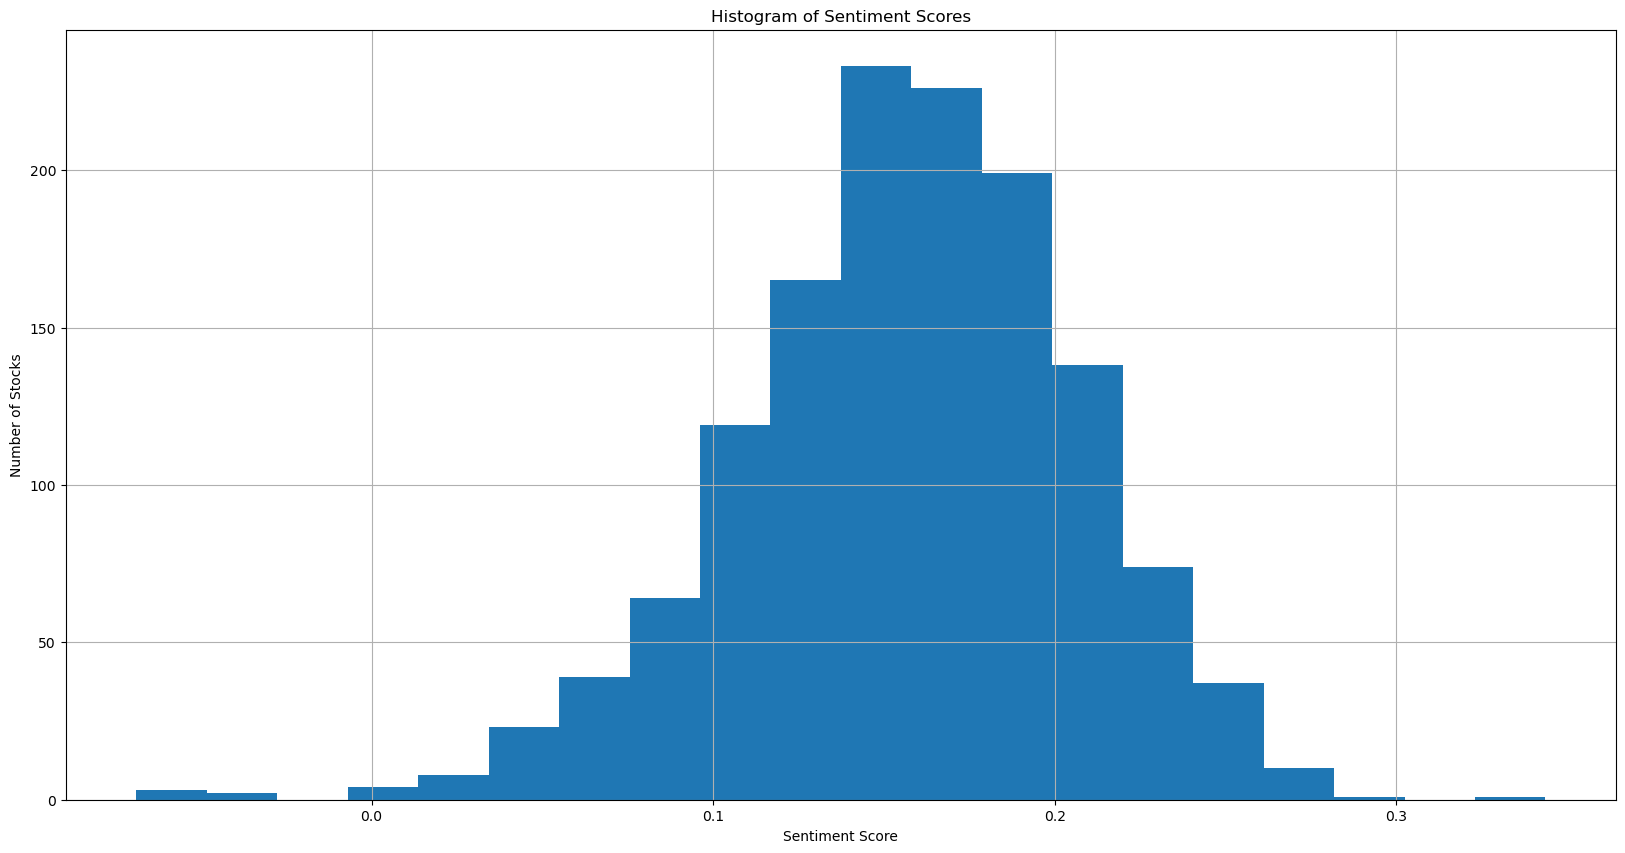

In [31]:
# Create a histogram of the sentiment scores
plt.figure(figsize=(20, 10))
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Stocks')
plt.grid()
plt.hist(df['sentiment'], bins=20)
plt.show()

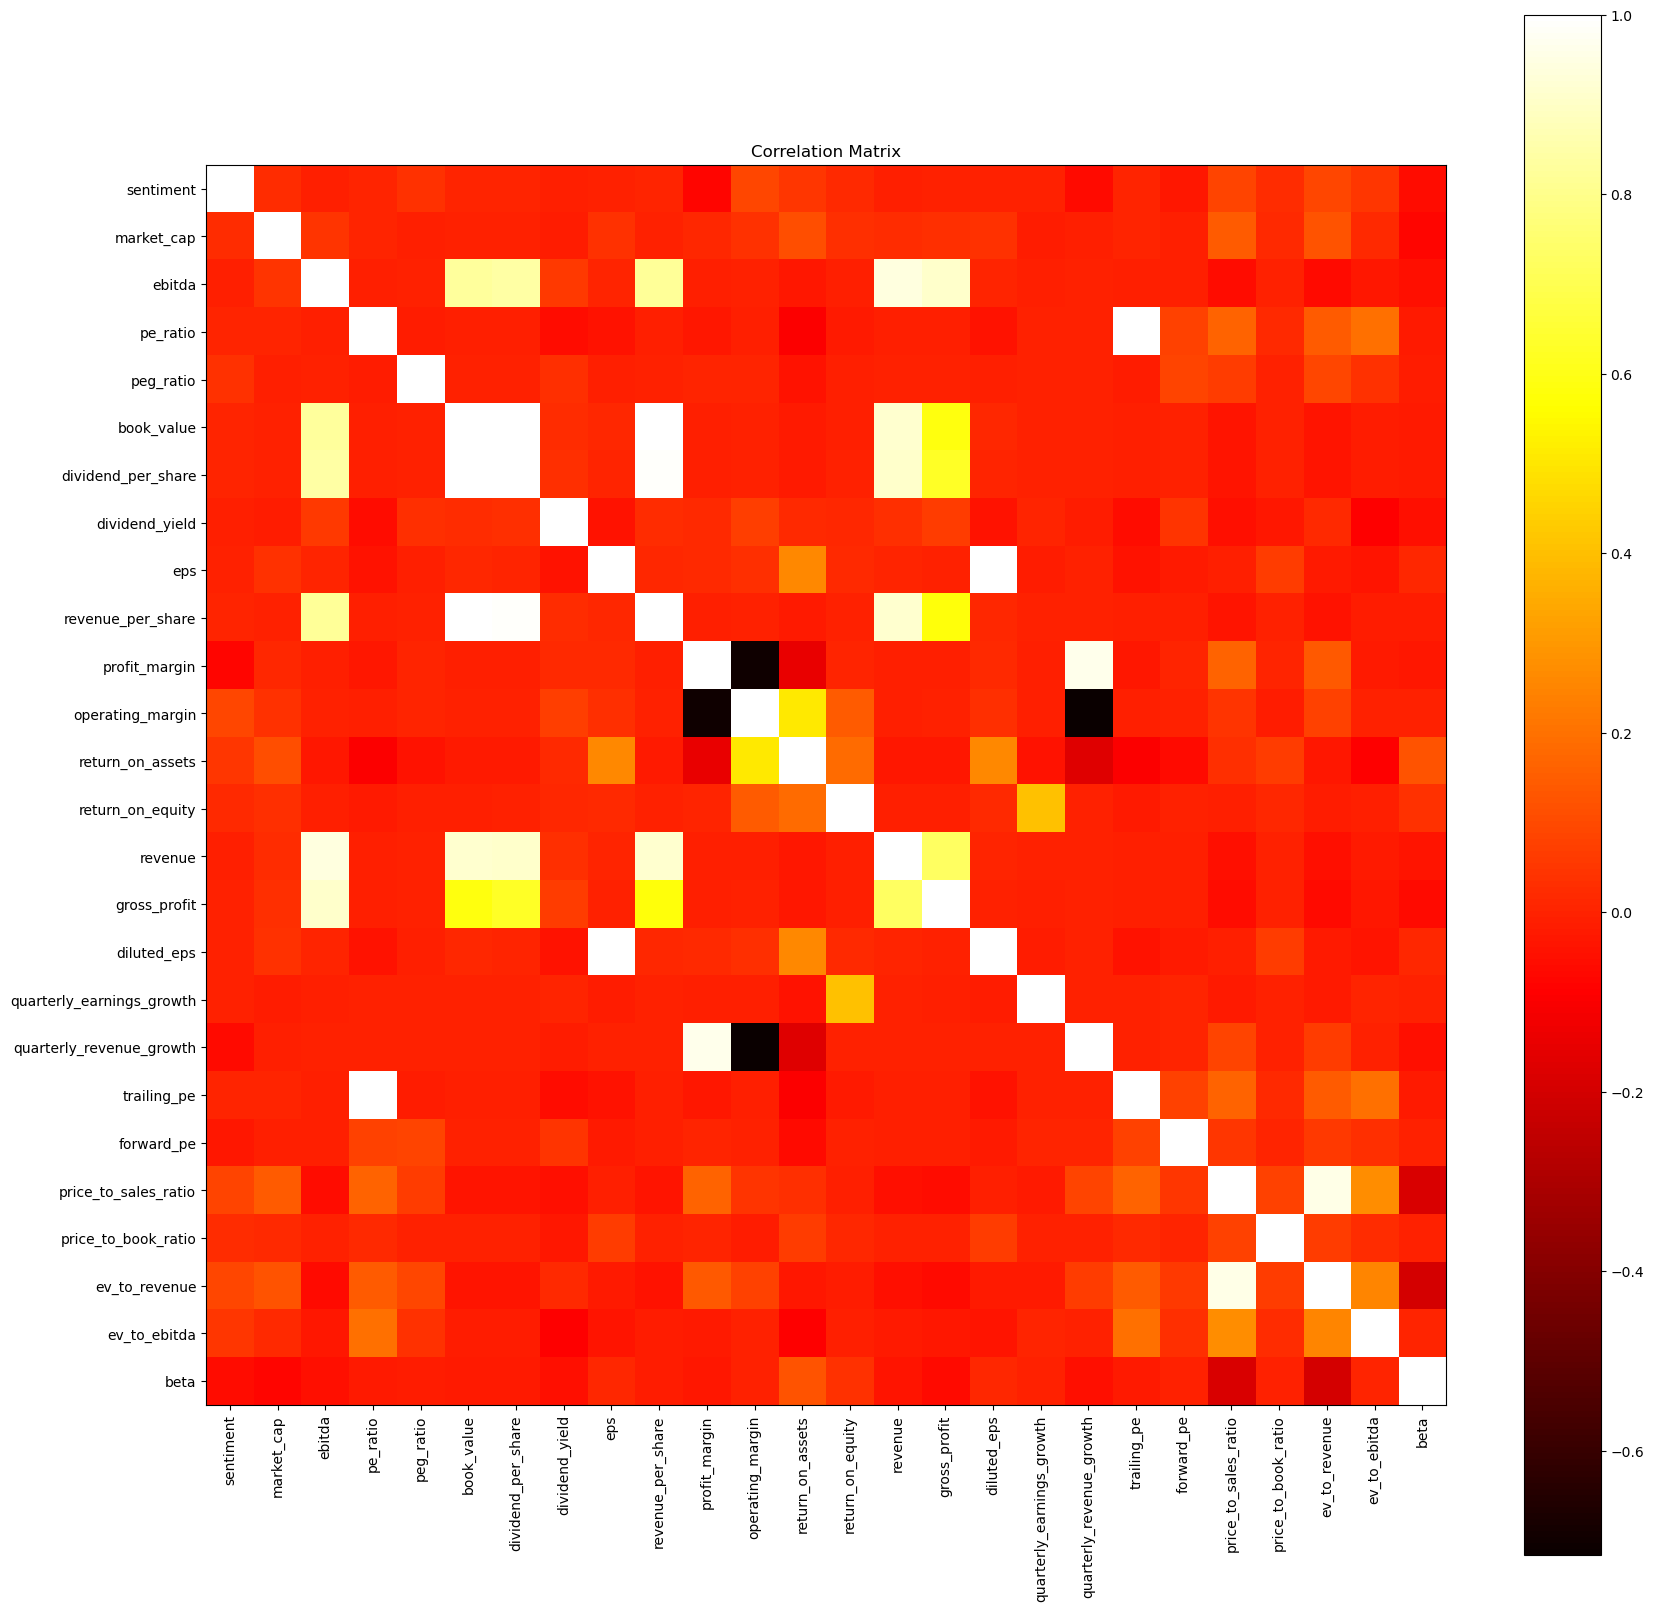

In [33]:
# Create a plot of the correlation matrix
plt.figure(figsize=(20, 20))
plt.title('Correlation Matrix')
plt.imshow(df[df.columns[:-1]].corr(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(0, 26, 1), df.columns[:-1], rotation=90)
plt.yticks(np.arange(0, 26, 1), df.columns[:-1])
plt.show()

In [46]:
# Evaluate a model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [47]:
# Get the feature data
X = df[df.columns[:-1]]
# Get the target data
y = df.iloc[:, -1]

mlist = [LogisticRegression(), Perceptron(), DecisionTreeClassifier(), RandomForestClassifier(),
         GradientBoostingClassifier(), AdaBoostClassifier()]

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Number of Features', 'Features', 'Model', 'Accuracy', 'Standard Deviation'])

for i in range(1, 27):
    for n in mlist:
        estimator = n
        selector = RFE(estimator, n_features_to_select=i)
        X_new = selector.fit_transform(X, y)
        scores = evaluate_model(estimator, X_new, y)
        accuracy = np.mean(scores)
        standard_deviation = np.std(scores)
        results = pd.concat(
            [results, pd.DataFrame(
                {'Number of Features': [i], 'Features': [selector.feature_names_in_], 'Model': [str(n)],
                 'Accuracy': [accuracy],
                 'Standard Deviation': [standard_deviation]})],
            ignore_index=True)

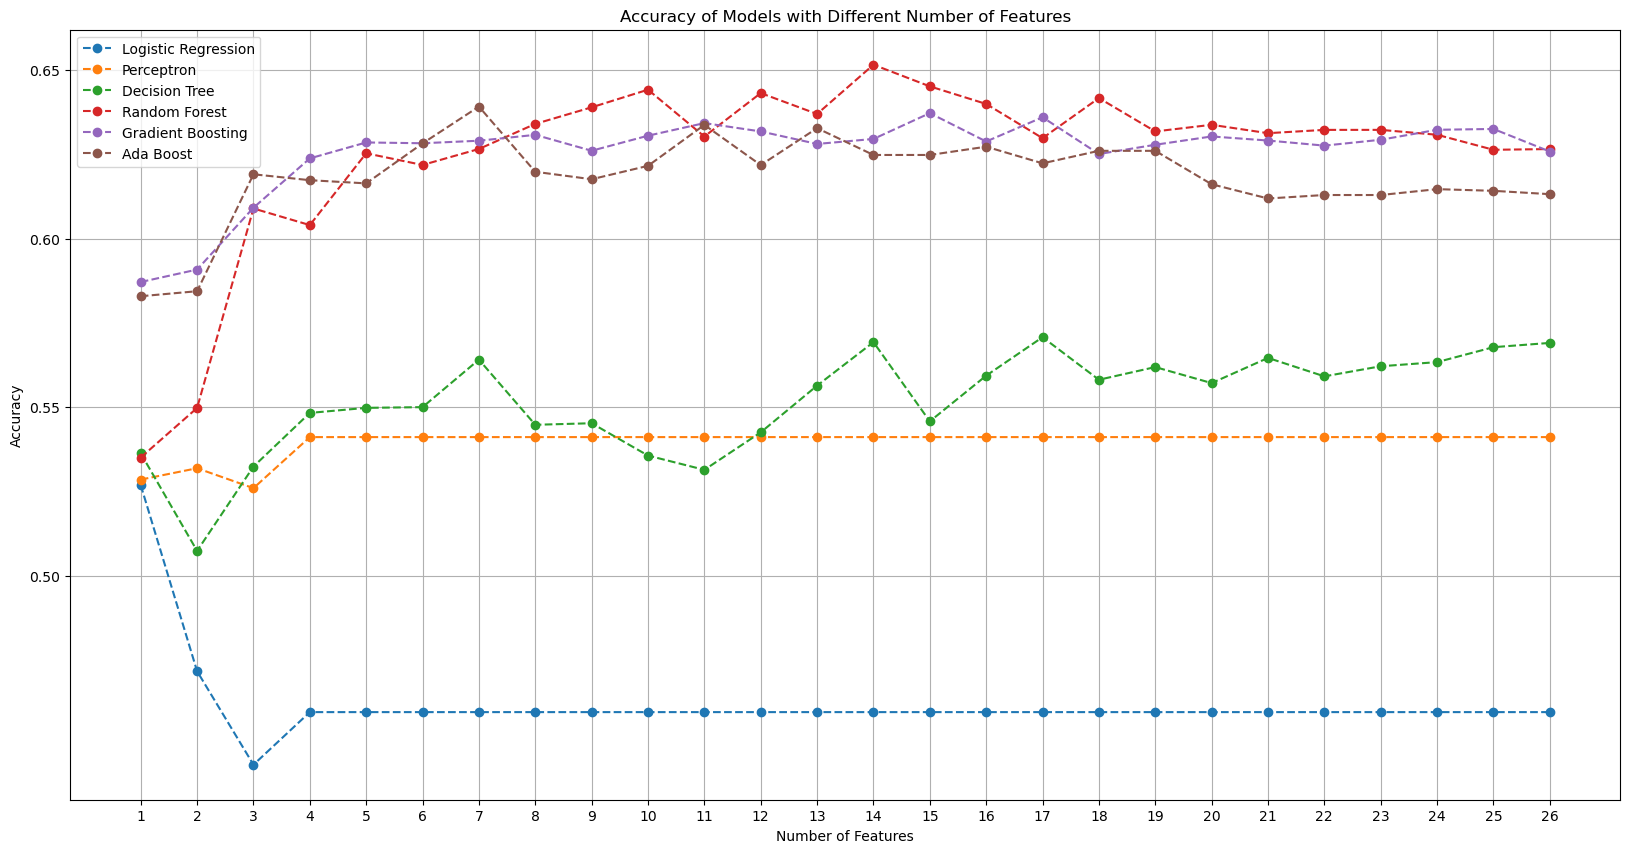

In [53]:
# Plot the results for each model
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Models with Different Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 27, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.grid()

# Plot and draw lines connecting the dots for each model
plt.plot(results[results['Model'] == 'LogisticRegression()'].iloc[:, 0],
         results[results['Model'] == 'LogisticRegression()'].iloc[:, 3], 'o', label='Logistic Regression',
         linestyle='--')
plt.plot(results[results['Model'] == 'Perceptron()'].iloc[:, 0],
         results[results['Model'] == 'Perceptron()'].iloc[:, 3], 'o', label='Perceptron', linestyle='--')
plt.plot(results[results['Model'] == 'DecisionTreeClassifier()'].iloc[:, 0],
         results[results['Model'] == 'DecisionTreeClassifier()'].iloc[:, 3], 'o', label='Decision Tree', linestyle='--')
plt.plot(results[results['Model'] == 'RandomForestClassifier()'].iloc[:, 0],
         results[results['Model'] == 'RandomForestClassifier()'].iloc[:, 3], 'o', label='Random Forest', linestyle='--')
plt.plot(results[results['Model'] == 'GradientBoostingClassifier()'].iloc[:, 0],
         results[results['Model'] == 'GradientBoostingClassifier()'].iloc[:, 3], 'o', label='Gradient Boosting',
         linestyle='--')
plt.plot(results[results['Model'] == 'AdaBoostClassifier()'].iloc[:, 0],
         results[results['Model'] == 'AdaBoostClassifier()'].iloc[:, 3], 'o', label='Ada Boost', linestyle='--')
plt.legend()
plt.show()

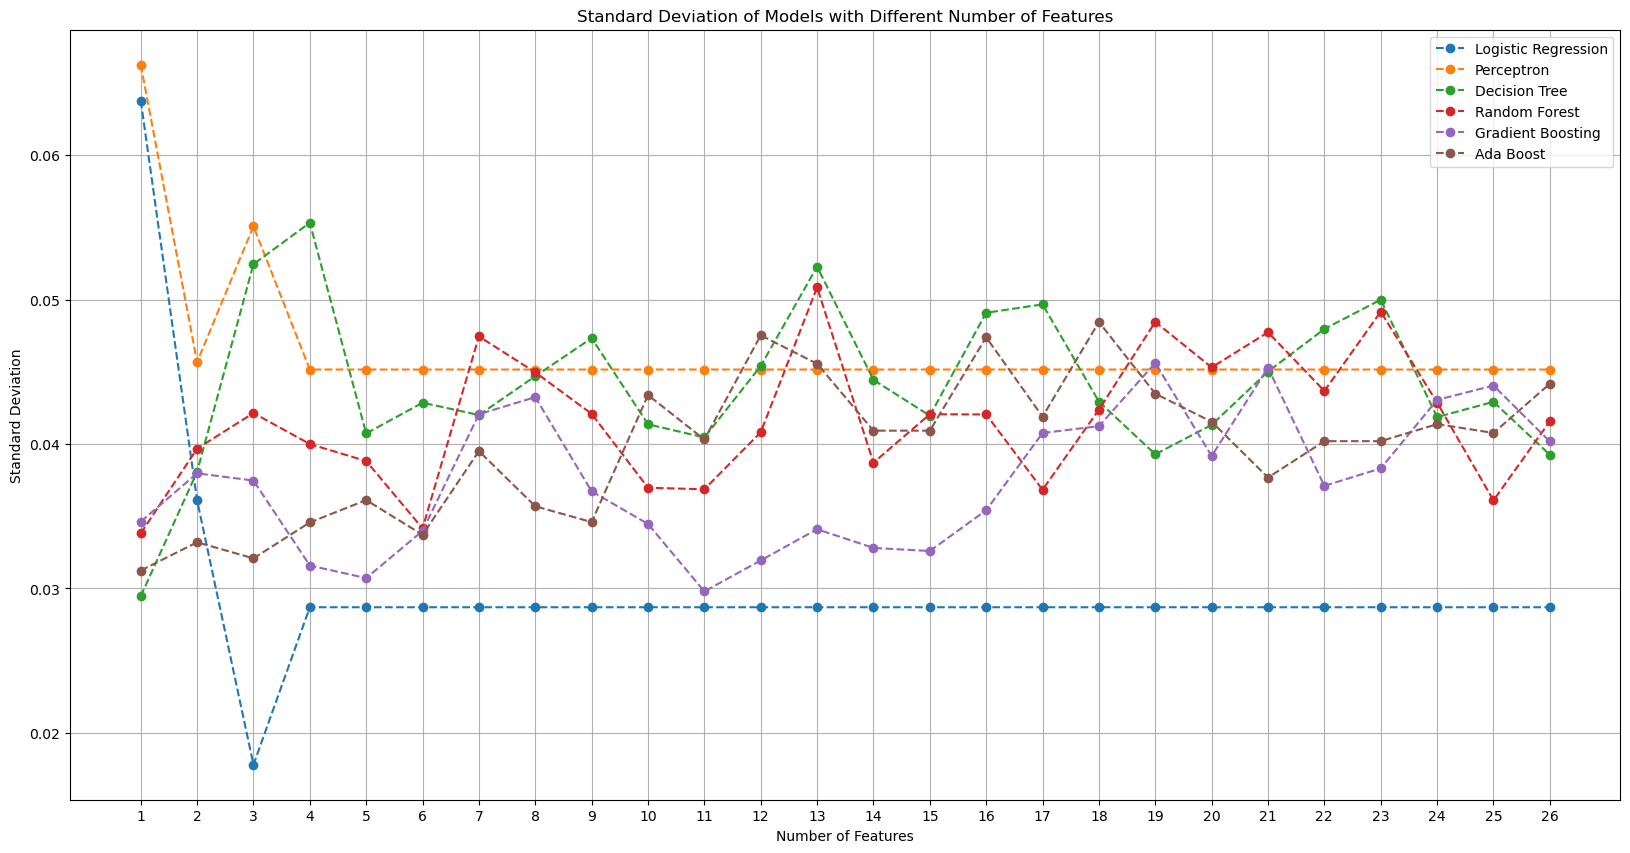

In [49]:
# Plot the results for each model
plt.figure(figsize=(20, 10))
plt.title('Standard Deviation of Models with Different Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Standard Deviation')
plt.xticks(np.arange(1, 27, 1))
plt.yticks(np.arange(0, 0.2, 0.01))
plt.grid()

# Plot and draw lines connecting the dots for each model
plt.plot(results[results['Model'] == 'LogisticRegression()'].iloc[:, 0],
         results[results['Model'] == 'LogisticRegression()'].iloc[:, 4], 'o', label='Logistic Regression',
         linestyle='--')
plt.plot(results[results['Model'] == 'Perceptron()'].iloc[:, 0],
         results[results['Model'] == 'Perceptron()'].iloc[:, 4], 'o', label='Perceptron', linestyle='--')
plt.plot(results[results['Model'] == 'DecisionTreeClassifier()'].iloc[:, 0],
         results[results['Model'] == 'DecisionTreeClassifier()'].iloc[:, 4], 'o', label='Decision Tree', linestyle='--')
plt.plot(results[results['Model'] == 'RandomForestClassifier()'].iloc[:, 0],
         results[results['Model'] == 'RandomForestClassifier()'].iloc[:, 4], 'o', label='Random Forest', linestyle='--')
plt.plot(results[results['Model'] == 'GradientBoostingClassifier()'].iloc[:, 0],
         results[results['Model'] == 'GradientBoostingClassifier()'].iloc[:, 4], 'o', label='Gradient Boosting',
         linestyle='--')
plt.plot(results[results['Model'] == 'AdaBoostClassifier()'].iloc[:, 0],
         results[results['Model'] == 'AdaBoostClassifier()'].iloc[:, 4], 'o', label='Ada Boost', linestyle='--')
plt.legend()
plt.show()

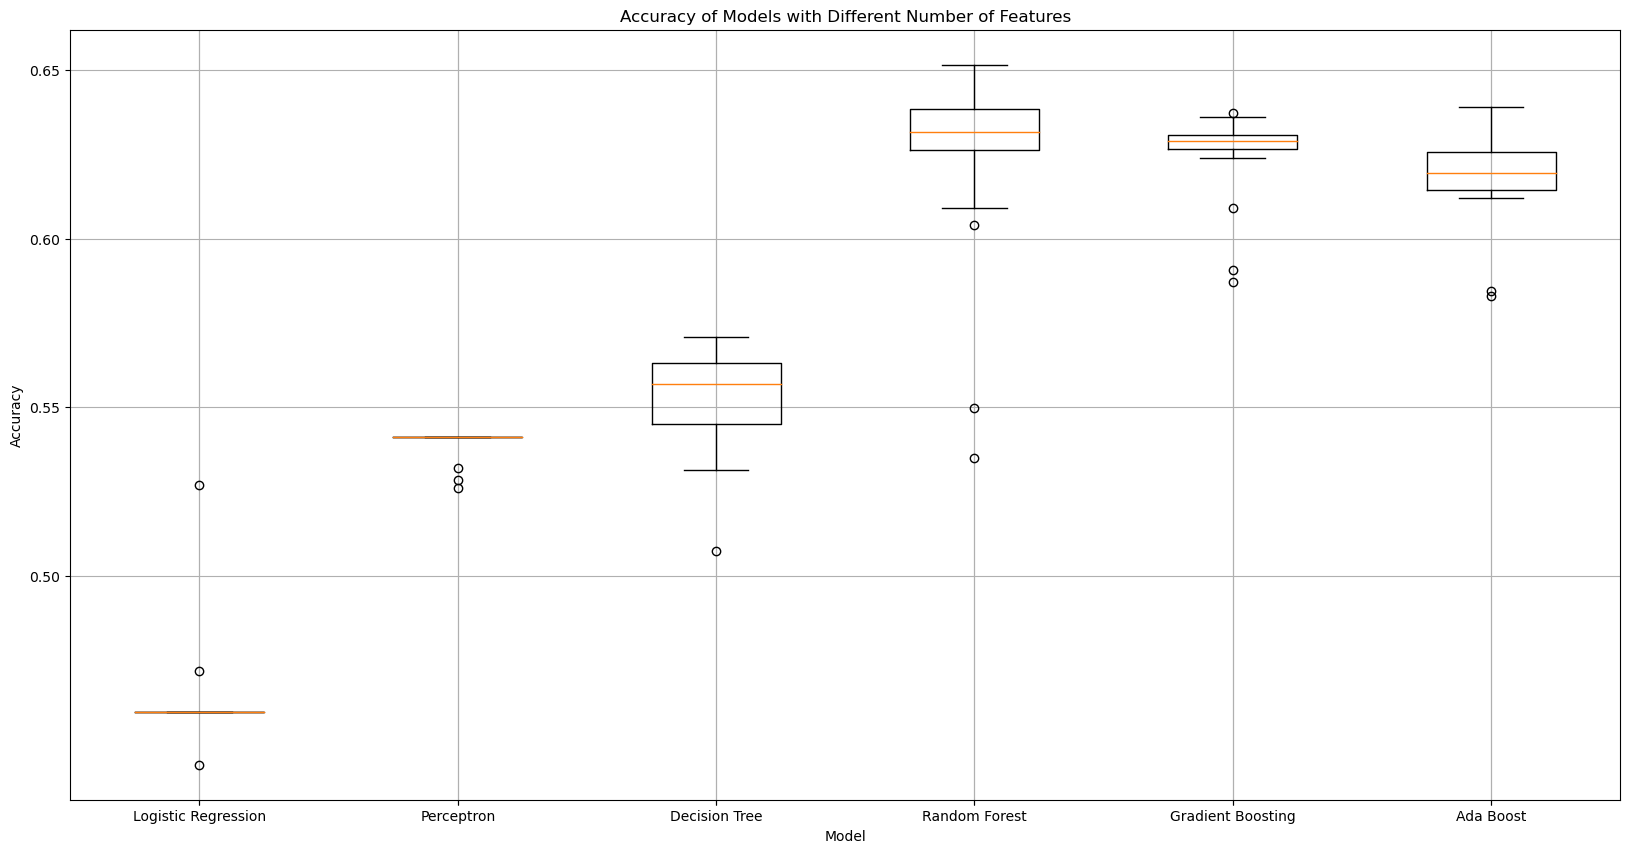

In [50]:
# Create boxplots for each model
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Models with Different Number of Features')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 7, 1))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.grid()

# Plot and draw lines connecting the dots for each model
plt.boxplot([results[results['Model'] == 'LogisticRegression()'].iloc[:, 3],
             results[results['Model'] == 'Perceptron()'].iloc[:, 3],
             results[results['Model'] == 'DecisionTreeClassifier()'].iloc[:, 3],
             results[results['Model'] == 'RandomForestClassifier()'].iloc[:, 3],
             results[results['Model'] == 'GradientBoostingClassifier()'].iloc[:, 3],
             results[results['Model'] == 'AdaBoostClassifier()'].iloc[:, 3]],
            labels=['Logistic Regression', 'Perceptron',
                    'Decision Tree', 'Random Forest',
                    'Gradient Boosting', 'Ada Boost'])
plt.show()

In [52]:
# Get the best model
best_model = results[results['Accuracy'] == results['Accuracy'].max()]
display(best_model)

,Number of Features,Features,Model,Accuracy,Standard Deviation
81,14,"[sentiment, market_cap, ebitda, pe_ratio, peg_...",RandomForestClassifier(),0.651574,0.038712


In [59]:
# Hyperparameter tune the best model
# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Number of Features', 'Features', 'Model', 'Accuracy', 'Standard Deviation'])
n_estimators = [25, 50, 100, 150]
max_features = ['sqrt', 'log2', None]
max_depth = [3, 6, 9]
max_leaf_nodes = [3, 6, 9]

for i in range(14, 17):
    for n in n_estimators:
        for m in max_features:
            for o in max_depth:
                for p in max_leaf_nodes:
                    estimator = RandomForestClassifier(n_estimators=n, max_features=m, max_depth=o, max_leaf_nodes=p)
                    selector = RFE(estimator, n_features_to_select=i)
                    X_new = selector.fit_transform(X, y)
                    scores = evaluate_model(estimator, X_new, y)
                    accuracy = np.mean(scores)
                    standard_deviation = np.std(scores)
                    results = pd.concat(
                        [results, pd.DataFrame(
                            {'Number of Features': [i], 'Features': [selector.feature_names_in_], 'Model': ['n_estimators: ' + str(n) + ', max_features: ' + str(m) + ', max_depth: ' + str(o) + ', max_leaf_nodes: ' + str(p)],
                             'Accuracy': [accuracy],
                             'Standard Deviation': [standard_deviation]})],
                        ignore_index=True)

In [60]:
# Get the best model
best_model = results[results['Accuracy'] == results['Accuracy'].max()]
display(best_model)

,Number of Features,Features,Model,Accuracy,Standard Deviation
50,14,"[sentiment, market_cap, ebitda, pe_ratio, peg_...","n_estimators: 50, max_features: None, max_dept...",0.623337,0.035144
